In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchio as tio
from torchsummary import summary

from enum import Enum

In [44]:



class RasterNet(nn.Module):
    class ResidualBlock(nn.Module):
        def __init__(self, in_ch, out_ch, stride=1, downsample=None):
            super(RasterNet.ResidualBlock, self).__init__()
            self.conv0 = nn.Sequential(
                nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm3d(out_ch),
                nn.ReLU()
            )
            self.conv1 = nn.Sequential(
                nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm3d(out_ch)
            )
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_ch = out_ch
            
        def forward(self, x):
            residual = x
            out = self.conv0(x)
            out = self.conv1(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out
            
    def __init__(self):
        super(RasterNet, self).__init__()
        self.inplanes = 64

        self.conv0 = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm3d(64),
            nn.ReLU()
        )

        self.layer0 = self._make_layer(RasterNet.ResidualBlock, 64,  3, stride=2)
        self.layer1 = self._make_layer(RasterNet.ResidualBlock, 128, 3, stride=2)
        self.layer2 = self._make_layer(RasterNet.ResidualBlock, 256, 4, stride=2)
        self.layer3 = self._make_layer(RasterNet.ResidualBlock, 512, 4, stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        self.fc0 = nn.Linear(512, 1024)
        self.fc1 = nn.Linear(1024, 1)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm3d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv0(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc0(x))
        x = self.fc1(x)
        
        return x
    
    @classmethod
    def expected_shape(cls):
        return (1, 96, 96, 96)

class Predictor:
    class Lenience(float, Enum):
        STRICT  = 0.09
        NORMAL  = 0.13
        LENIENT = 0.18

    def __init__(self, weights_path, norm_path):
        self.model = RasterNet()
        self.model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
        self.model.eval()

        norm_json = json.load(open(norm_path, 'r'))
        self.voxels_mean = norm_json['voxels_mean']
        self.voxels_std = norm_json['voxels_std']
        self.voxels_min = norm_json['voxels_min']
        self.voxels_max = norm_json['voxels_max']

        self.norm_transform = tio.Compose([
            tio.transforms.RescaleIntensity(), 
            tio.transforms.ZNormalization()
        ])

        self.bayes_transform = tio.Compose([
            tio.transforms.RandomAffine(scales=0, degrees=20, translation=0.25, default_pad_value='minimum', p=0.8),
            tio.transforms.RandomFlip(axes=(0, 1, 2), flip_probability=0.3),
            tio.transforms.RandomAnisotropy(axes=(0, 1, 2), p=0.3),
            tio.transforms.RandomNoise(mean=0, std=0.2, p=0.3),
            tio.transforms.RandomBlur(std=0.2, p=0.3)
        ])

    def __call__(self, raster, voxel_spacings, bayes_runs=None, lenience=Lenience.NORMAL):
        raster, voxel_spacings = self._prepare_raster(raster, voxel_spacings)
        raster = torch.from_numpy(raster).unsqueeze(0).float()
        norm_raster = self.norm_transform(raster).unsqueeze(0)

        with torch.no_grad():
            voxels = self.model(norm_raster).item()
            
            if bayes_runs:
                bayes_voxels = np.zeros(bayes_runs)
                for i in range(bayes_runs):
                    bayes_raster = self.bayes_transform(raster)
                    norm_bayes_raster = self.norm_transform(bayes_raster).unsqueeze(0)
                    bayes_voxels[i] = self.model(norm_bayes_raster).item()
                error = np.std(bayes_voxels)

                print(f'Error: {round(error, 3)} | Lenience: {lenience.value}')
                if error > lenience.value:
                    return None
            
            voxels = voxels * self.voxels_std + self.voxels_mean
            voxels = voxels * (self.voxels_max - self.voxels_min) + self.voxels_min

            return round(voxels * np.prod(voxel_spacings), 2)
    
    def _prepare_raster(self, raster, voxel_spacings):
        old_sizes = np.array(raster.shape)
        old_spacings = voxel_spacings
        new_sizes = np.array(RasterNet.expected_shape()[1:])

        if np.array_equal(old_sizes, new_sizes):
            return raster, voxel_spacings
        
        resize_factors = new_sizes / old_sizes

        raster = scipy.ndimage.zoom(raster, resize_factors)
        new_spacings = old_spacings / resize_factors

        return raster, new_spacings


In [45]:
predictor = Predictor("/home/daru/code/tbv/visualizer/network/weights.pt", "/home/daru/code/tbv/visualizer/network/norm.json")

In [46]:
summary(predictor.model, (1, 96, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 48, 48, 48]          22,016
       BatchNorm3d-2       [-1, 64, 48, 48, 48]             128
              ReLU-3       [-1, 64, 48, 48, 48]               0
            Conv3d-4       [-1, 64, 24, 24, 24]         110,656
       BatchNorm3d-5       [-1, 64, 24, 24, 24]             128
              ReLU-6       [-1, 64, 24, 24, 24]               0
            Conv3d-7       [-1, 64, 24, 24, 24]         110,656
       BatchNorm3d-8       [-1, 64, 24, 24, 24]             128
            Conv3d-9       [-1, 64, 24, 24, 24]           4,160
      BatchNorm3d-10       [-1, 64, 24, 24, 24]             128
             ReLU-11       [-1, 64, 24, 24, 24]               0
    ResidualBlock-12       [-1, 64, 24, 24, 24]               0
           Conv3d-13       [-1, 64, 24, 24, 24]         110,656
      BatchNorm3d-14       [-1, 64, 24,

In [47]:
def show_layer(layer):
    print(layer)

def get_convolutions(model):
    convolutions = []
    for layer in model.children():
        if layer._get_name() == 'Sequential':
            for sublayer in layer.children():
                if "Conv" in sublayer._get_name():
                    convolutions.append(sublayer)
                elif sublayer._get_name() == "ResidualBlock":
                    for subsublayer in sublayer.children():
                        if layer._get_name() == 'Sequential':
                            for subsubsublayer in subsublayer.children():
                                if "Conv" in subsubsublayer._get_name():
                                    convolutions.append(subsubsublayer)
    return convolutions


In [48]:
convolution_layers = get_convolutions(predictor.model)
convolution_layers

[Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3)),
 Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
 Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
 Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(2, 2, 2)),
 Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
 Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
 Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
 Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
 Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
 Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
 Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(2, 2, 2)),
 Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
 Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
 Conv3d(128, 128, kernel_size=

In [49]:
weights0 = convolution_layers[0].weight.detach().numpy()
weights0.shape

(64, 1, 7, 7, 7)

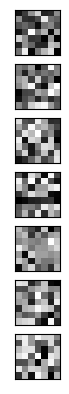

In [60]:
# https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

# Normalize between 0 and 1
weights0 = (weights0 - weights0.min()) / (weights0.max() - weights0.min())

outgoing_channels = 1
n_filters, ix = outgoing_channels, 1
for i in range(n_filters):
    # get the filter
    f = weights0[i]
    # plot each channel separately
    # Range of incoming channels
    incoming_channels = 1
    for j in range(incoming_channels):
        # Range of Depth of the kernel .i.e. 3
        depth = 7
        for k in range(depth):
            # specify subplot and turn of axis
            ax = plt.subplot((outgoing_channels*7), incoming_channels, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[j, :, :, k], cmap='gray')
            ix += 1
# show the figure
plt.show()
